![alt text](traffic3.PNG "Traffic Image")

# Dataset

<font size="3"> The case study is based on anonymous probe-based speed measurements of individual cars for a single road segment.The dataset has four columns: Timestamp, Speed_kph, MapMatchingError_m, and ProbeSource. 
<ul><ul><li>Timestamp: ingress time of the vehicle on the road segment
&nbsp;<li>Speed_kph: average speed of the vehicle for the road segment
&nbsp;<li>MapMatchingError: average perpendicular GPS-fix distance in m to the centerline of the road element     
&nbsp;<li>ProbeSource: flag for indicating the data provider (e.g. automotive brand x, ...)

# Objective

<font size="3">
The objectives of the case study are: (1) to find the temporal patterns in the speed, GPS error, and the number of cars per hour, (2) to find if the observed GPS errors vary by the device manufacturer, and (3) develop initial time series model to predict the number of cars per hour
    </font>  

# Reading and Creating Dataset

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import strptime
import seaborn as sns
from datetime import datetime
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from pandas.core.common import flatten
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from pmdarima.arima import auto_arima
import matplotlib
import math
import time
import datetime

In [79]:
#importing the dataset
DataCaseStudy_Traffic = pd.read_csv("C:\\Users\\31685\\Documents\\tom_tom\\example3.csv", header=None)

In [80]:
#Renaming the columns
DataCaseStudy_Traffic.columns = ["Timestamp","Speed_kph","MapMatchingError_m","ProbeSource"]

In [83]:
#Removing underscore from the Timestamp columns
Timestamp_with_space = []
for i in range(0,DataCaseStudy_Traffic.shape[0]):
    Timestamp_with_space.append(DataCaseStudy_Traffic.Timestamp[i].replace('_',' ')) 

In [84]:
#adding the time stamp with space to the case study data
DataCaseStudy_Traffic['Timestamp_space'] = pd.to_datetime(Timestamp_with_space)

In [6]:
#the first five rows of the dataset
DataCaseStudy_Traffic.head()

,Timestamp,Speed_kph,MapMatchingError_m,ProbeSource,Timestamp_space
0,2017.11.15_17:19:56,30.25,10,0,2017-11-15 17:19:56
1,2017.11.15_17:17:13,7.66,--,1,2017-11-15 17:17:13
2,2017.11.15_17:15:27,32.75,--,2,2017-11-15 17:15:27
3,2017.11.15_17:15:21,38.25,14,3,2017-11-15 17:15:21
4,2017.11.15_17:13:52,29.38,--,1,2017-11-15 17:13:52


In [85]:
#Creating additional Temporal varibles
DataCaseStudy_Traffic['Date'] = DataCaseStudy_Traffic['Timestamp_space'].dt.date
DataCaseStudy_Traffic['Time'] = DataCaseStudy_Traffic['Timestamp_space'].dt.time
DataCaseStudy_Traffic['DayofWeek'] = DataCaseStudy_Traffic['Timestamp_space'].dt.dayofweek
DataCaseStudy_Traffic['Week'] = DataCaseStudy_Traffic['Timestamp_space'].dt.week
DataCaseStudy_Traffic['Year'] = DataCaseStudy_Traffic['Timestamp_space'].dt.year
DataCaseStudy_Traffic['Hour'] = DataCaseStudy_Traffic['Timestamp_space'].dt.hour

<ipython-input-85-a899b45ab69b>:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  DataCaseStudy_TomTom['Week'] = DataCaseStudy_TomTom['Timestamp_space'].dt.week


In [86]:
#Creating(recoding) temporal variables  
DataCaseStudy_Traffic['Year_Week']=DataCaseStudy_Traffic.apply(lambda x:'%s-%s' % (x['Year'],x['Week']),axis=1)
DataCaseStudy_Traffic['Year_Month'] = DataCaseStudy_Traffic['Timestamp_space'].dt.strftime('%Y-%m')

In [87]:
#Replacing numeric values of dayofweek with the actual names of the days
DataCaseStudy_Traffic = DataCaseStudy_Traffic.replace({'DayofWeek' : { 0 : 'Monday', 1 : 'Tuesday', 2 : 'Wednesday', 3 : 'Thursday', 4 : 'Friday', 5 : 'Saturday', 6 : 'Sunday'}})

In [88]:
#Classifying days as weekday and weekend
DataCaseStudy_Traffic['DayType'] = DataCaseStudy_Traffic['DayofWeek'].apply(lambda x: "weekday" if x in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'] else "weekend")

In [93]:
#Recoding the time as morning peak, afternoon peak, night off peak, and Day off peak
TimeClass = []
for i in range(0, DataCaseStudy_Traffic.shape[0]):
    if (datetime.time(hour=6, minute=30) < DataCaseStudy_Traffic['Time'][i] < datetime.time(hour=9, minute=0)):
        TimeClass.append("Morning_Peak")
    elif (datetime.time(hour=16, minute=0) < DataCaseStudy_Traffic['Time'][i] < datetime.time(hour=18, minute=30)): 
        TimeClass.append("Afternoon_Peak")       
    elif (datetime.time(hour=18, minute=30) < DataCaseStudy_Traffic['Time'][i] < datetime.time(hour=23, minute=59,second=59,microsecond = 999999 )) or (datetime.time(hour=0, minute=0) < DataCaseStudy_Traffic['Time'][i] < datetime.time(hour=6, minute=30)):
        TimeClass.append("Night_off_Peak")           
    else:
        TimeClass.append("Day_off_Peak")       

<font size="3"> The above code classifies each hours as: morning peak (6:30 - 9:00), day off peak (9:00 - 16:00), night peak ( 16:00 - 18:30), and night off peak (0:00 - 6:30 and 18:30 - 0:00).

In [94]:
#Including the recoded hours(TimeClass) to our data
DataCaseStudy_Traffic['TimeClass'] = TimeClass

# Exploratory Data Analysis

## Speed by TimeClass

<font size="3"> TimeClass has four categories: Afternoon_Peak, Day_off_Peak, Morning_Peak, and Night_off_Peak. The categories are defined following Nederlandse Spoorwegen(NS) peak hour definition. The aim is to see: (1) if the average speed of the car depends on those categories, and (2) to track changes in the speed. A change in the average speed might be an indication of a change in the traffic flow. 

In [174]:
#Computing the average speed of the cars by TimeClass 
DateTimeClass_Mean = DataCaseStudy_Traffic[['Date','TimeClass','Speed_kph']].groupby(['Date','TimeClass']).mean()
DateTimeClass_Mean = DateTimeClass_Mean.unstack(level='TimeClass')

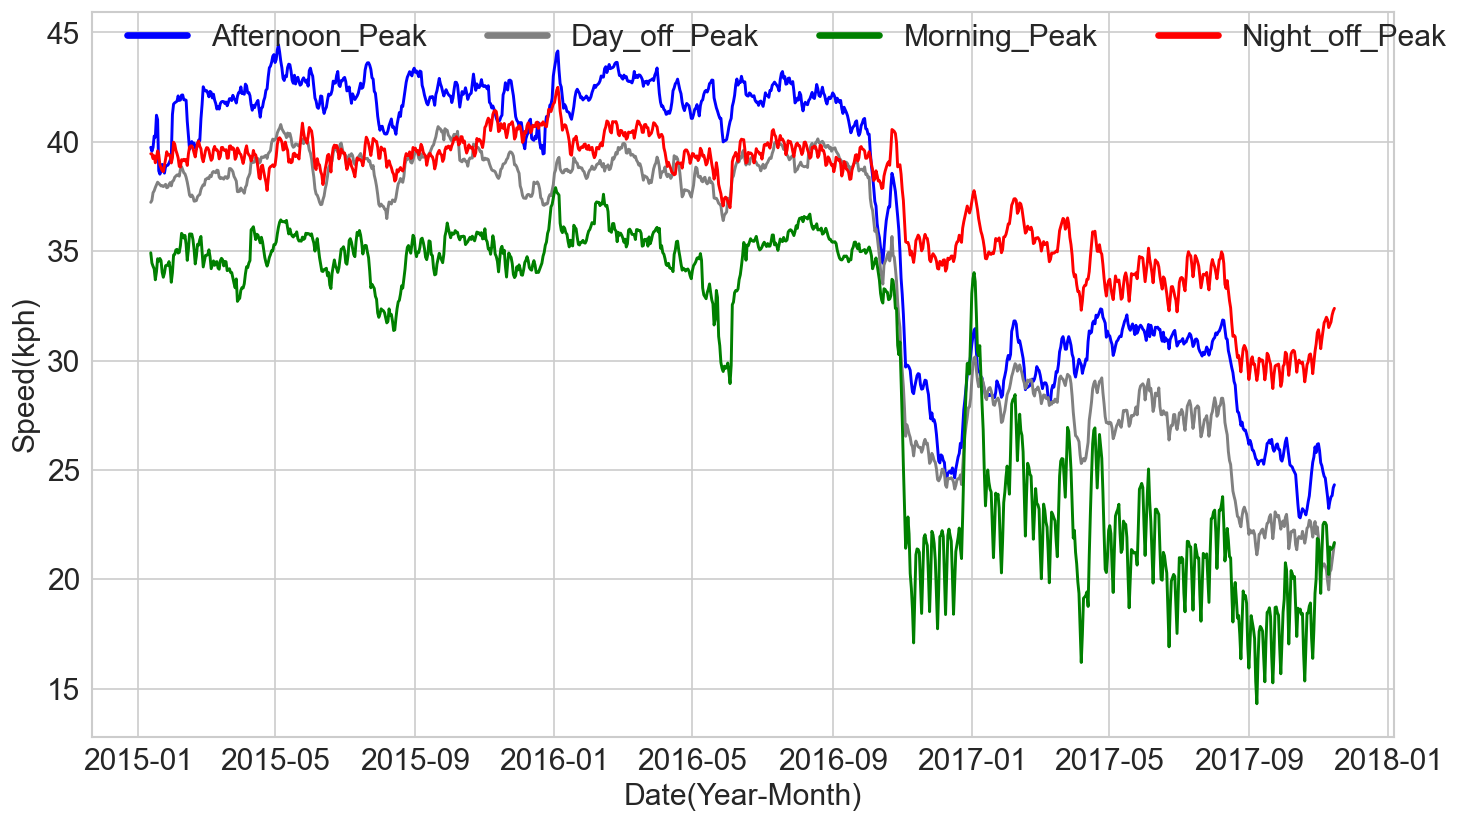

In [97]:
#Visualizing the average speed of cars  by TimeClass over years
plt.figure(figsize=(14,8))
plt.plot(DateTimeClass_Mean['Speed_kph', 'Afternoon_Peak'].rolling(12).mean(), c='blue')
plt.plot(DateTimeClass_Mean['Speed_kph',   'Day_off_Peak'].rolling(12).mean(), c='gray')
plt.plot(DateTimeClass_Mean['Speed_kph',   'Morning_Peak'].rolling(12).mean(), c='green')
plt.plot(DateTimeClass_Mean['Speed_kph', 'Night_off_Peak'].rolling(12).mean(), c='red')
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
plt.xlabel("Date(Year-Month)", fontsize=18)
plt.ylabel("Speed(kph)", fontsize=18)
colors = ['blue',  'gray', 'green', 'red']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['Afternoon_Peak', 'Day_off_Peak', 'Morning_Peak', 'Night_off_Peak']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0,ncol=4, fontsize=18,markerscale=4, title_fontsize='40')


<font size="3"> For all TimeClass categories, the average speed has dropped after November 2016. Also, throughout the given time period, relative to other TimeClass categories cars moves slowly during Morning_Peak hours. 

## Speed by DayofWeek

In [16]:
#Computing the average speed of the cars by DayofWeek
Year_MonthDayofWeek_Mean = DataCaseStudy_Traffic[['Year_Month', 'DayofWeek','Speed_kph']].groupby(['Year_Month','DayofWeek']).mean()
Year_MonthDayofWeek_Mean = Year_MonthDayofWeek_Mean.unstack(level='DayofWeek')
Year_MonthDayofWeek_Mean.index = pd.to_datetime(Year_MonthDayofWeek_Mean.index)

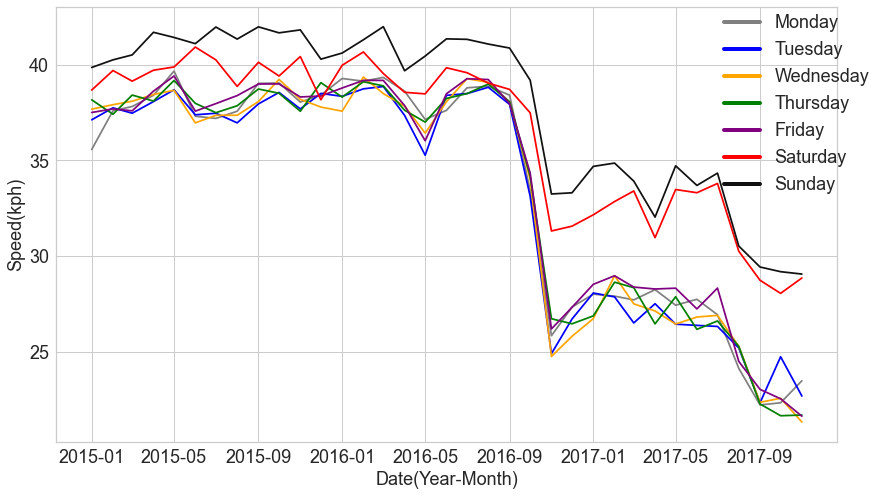

In [17]:
#Visualizing the average speed of cars by DayofWeek
plt.figure(figsize=(14,8))
plt.plot(Year_MonthDayofWeek_Mean['Speed_kph',    'Monday'], c='gray' )
plt.plot(Year_MonthDayofWeek_Mean['Speed_kph',    'Tuesday'] , c='blue')
plt.plot(Year_MonthDayofWeek_Mean['Speed_kph',    'Wednesday'] , c='orange')
plt.plot(Year_MonthDayofWeek_Mean['Speed_kph',    'Thursday'], c='green')
plt.plot(Year_MonthDayofWeek_Mean['Speed_kph',    'Friday'], c='purple')
plt.plot(Year_MonthDayofWeek_Mean['Speed_kph',  'Saturday'], c='red')
plt.plot(Year_MonthDayofWeek_Mean['Speed_kph',    'Sunday'], c='k')
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
plt.xlabel("Date(Year-Month)", fontsize=18)
plt.ylabel("Speed(kph)", fontsize=18)
colors = ['gray',  'blue', 'orange', 'green', 'purple', 'red','k']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.,ncol=1, fontsize=18,markerscale=4, title_fontsize='40')


<font size="3"> The above line plots show the difference in the speed of cars by DayofWeek. According to the figure, the speed patterns for weekends and weekdays are different. Relatively, cars move faster during weekends.    

## Speed by DayType

In [110]:
#Finding the mean speed for DayType (weekend vs. weekday)
DateTimeClass = DataCaseStudy_Traffic[['Date','DayType','Hour','Speed_kph']].groupby(['Date','DayType','Hour']).mean()
DateTimeClass = DateTimeClass.unstack(level='Hour')
DateTimeClass['Date'] =  DateTimeClass.index.get_level_values(0)
DateTimeClass['DayType'] = DateTimeClass.index.get_level_values(1)

In [111]:
#Creating a column of colors for visualization
DateTimeClass['col'] = DateTimeClass['DayType'].apply(lambda x: "b" if x in ['weekday'] else "r")

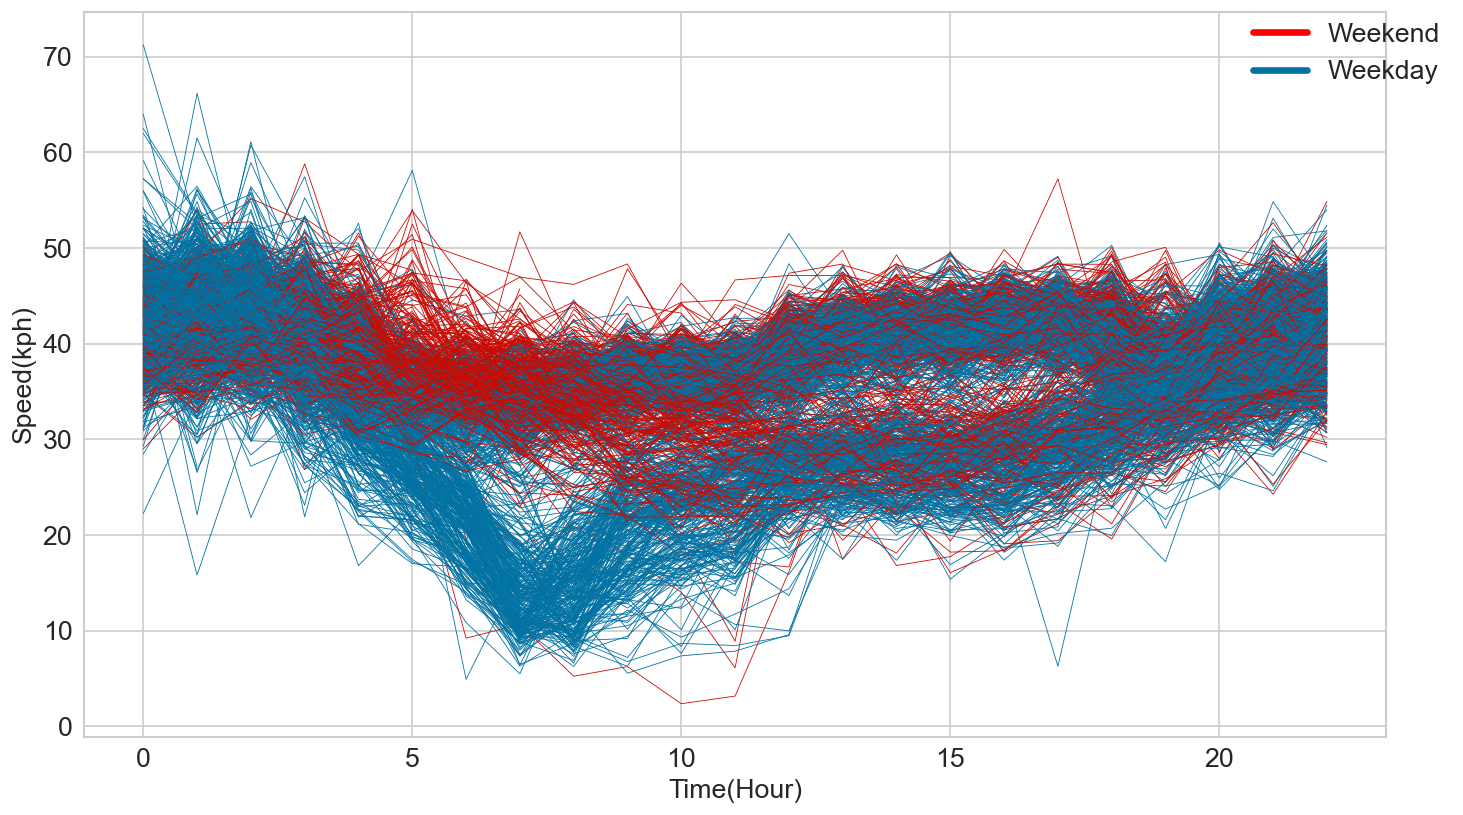

In [113]:
#Visualizing the average speed by DayType
plt.figure(figsize=(14,8))
for i in range(0,DateTimeClass.shape[0]):
    plt.plot(list(DateTimeClass.iloc[i,0:23]), c=DateTimeClass.col[i], linewidth = 0.5)
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Time(Hour)", fontsize=16)
plt.ylabel("Speed(kph)", fontsize=16)
colors = ['red','b']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['Weekend', 'Weekday']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.,ncol=1, fontsize=16,markerscale=1, title_fontsize='16')
#consistency in time classes

<font size="3"> In the above figure, each line represents the average speed at a different time point of a day. The figure shows the presence of differences in the average speed for weekends and weekdays. For instance, for weekdays, the average speed starts dropping at around 5 am and reaches its lowest at around 7 am, but for weekends, the average speed is relatively constant throughout the day. 

## MapMatchingError by TimeClass

In [102]:
#Replacing --in the MapMatchingError_m by np.nan and converting 
DataCaseStudy_Traffic['MapMatchingError_m'] = DataCaseStudy_Traffic.MapMatchingError_m.replace("--",np.nan)
DataCaseStudy_Traffic['MapMatchingError_m'] = DataCaseStudy_Traffic['MapMatchingError_m'].astype(float)

In [ ]:
#Computing the mean MapMatchingError by Date and TimeClass
DateTimeClass_Mean = DataCaseStudy_Traffic[['Date','TimeClass','MapMatchingError_m']].groupby(['Date','TimeClass']).mean()
DateTimeClass_Mean = DateTimeClass_Mean.unstack(level='TimeClass')

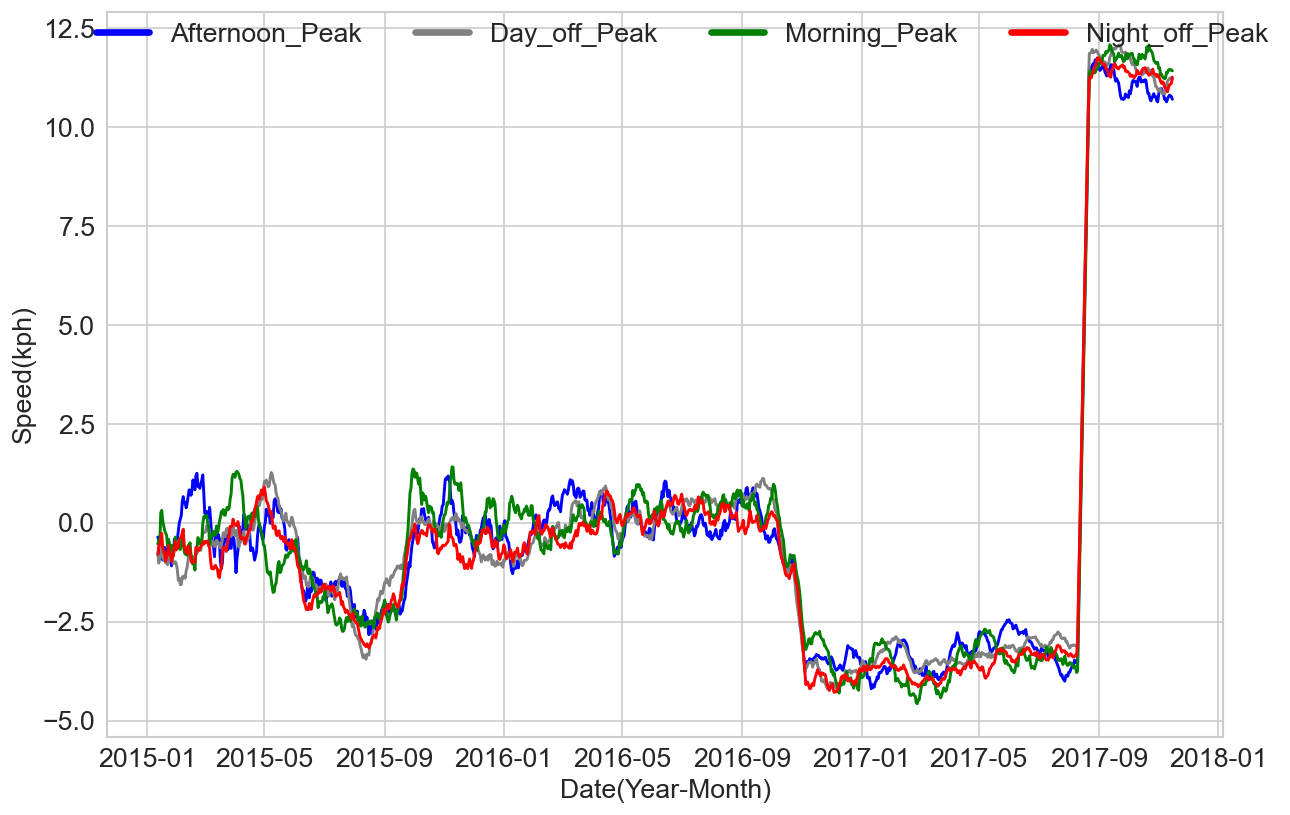

In [108]:
#Visualizing the mean map matching error by TimeClass
plt.figure(figsize=(12,8))
plt.plot(DateTimeClass_Mean['MapMatchingError_m', 'Afternoon_Peak'].rolling(12).mean(), c= 'blue')
plt.plot(DateTimeClass_Mean['MapMatchingError_m',   'Day_off_Peak'].rolling(12).mean(), c= 'gray')
plt.plot(DateTimeClass_Mean['MapMatchingError_m',   'Morning_Peak'].rolling(12).mean(), c= 'green')
plt.plot(DateTimeClass_Mean['MapMatchingError_m', 'Night_off_Peak'].rolling(12).mean(), c= 'red')

matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Date(Year-Month)", fontsize=16)
plt.ylabel("Speed(kph)", fontsize=16)
colors = ['blue',  'gray', 'green', 'red']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['Afternoon_Peak', 'Day_off_Peak', 'Morning_Peak', 'Night_off_Peak']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.,ncol=4, fontsize=16,markerscale=3, title_fontsize='40')


<font size="3"> The above line plot presents the mean map matching errors (MapMatchingError) by the categories of TimeClass. The hypothesis is that when there is congestion a car moves slowly which in turn leads to less map matching error. However, according to the above figure map matching errors for the four categories are not significantly different. The patterns in map matching error seem to exhibit sudden rise and fall that then stays for a certain period. 

## MapMatchingError by DayofWeek

In [19]:
#Computing the mean MapMatchingError by DayofWeek
Year_MonthDayofWeek_Mean = DataCaseStudy_Traffic[['Year_Month', 'DayofWeek','MapMatchingError_m']].groupby(['Year_Month','DayofWeek']).mean()
Year_MonthDayofWeek_Mean = Year_MonthDayofWeek_Mean.unstack(level='DayofWeek')

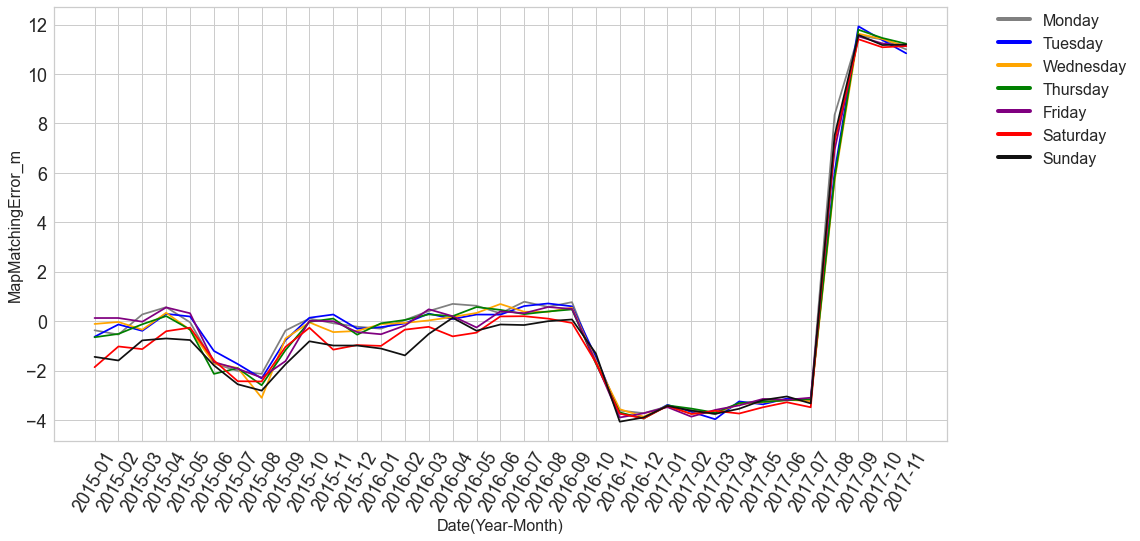

In [20]:
#Visualizing the mean map matching error by DayofWeek
plt.figure(figsize=(16,8))
plt.plot(Year_MonthDayofWeek_Mean['MapMatchingError_m',    'Monday'], c= 'gray')
plt.plot(Year_MonthDayofWeek_Mean['MapMatchingError_m',    'Tuesday'], c = 'blue')
plt.plot(Year_MonthDayofWeek_Mean['MapMatchingError_m',    'Wednesday'], c= 'orange')
plt.plot(Year_MonthDayofWeek_Mean['MapMatchingError_m',    'Thursday'], c = 'green')
plt.plot(Year_MonthDayofWeek_Mean['MapMatchingError_m',    'Friday'], c = 'purple' )
plt.plot(Year_MonthDayofWeek_Mean['MapMatchingError_m',  'Saturday'], c= 'red')
plt.plot(Year_MonthDayofWeek_Mean['MapMatchingError_m',    'Sunday'], c= 'k')

matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Date(Year-Month)", fontsize=16)
plt.ylabel("MapMatchingError_m", fontsize=16)

matplotlib. pyplot. xticks(rotation=60)
colors = ['gray',  'blue', 'orange', 'green', 'purple', 'red','k']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=1, fontsize=16,markerscale=4, title_fontsize='40')
#consistency in time classes

<font size="3"> Similar to the visualization presented in section 4.4, the average map matching error for the categories of the day of the week is similar.  

## Analyzing Number of Cars 

In [27]:
#A function to count the number of cars per hour for DayofWeek, DayType, and date 
def car_counter(df):
    
    """ 
     This function takes a pandas dataframe with datetime index, and returns per 
     hour number of car by (1) Day & WeekHour, (2) Day & ClassHour, and (3) Date. . 
    """
    
    #Counting the number of cars(samples) by day of the week and hour
    df['Indicator'] = np.repeat(1,df.shape[0])
    DayofWeekHour_Sum = df[['DayofWeek','Hour','Indicator']].groupby(['DayofWeek','Hour']).sum()
    DayofWeekHour_Sum = DayofWeekHour_Sum.unstack(level='Hour')
    DayofWeekHour_Sum['DayofWeek'] = DayofWeekHour_Sum.index.get_level_values(0)
    
    #Counting the number of cars(samples) by day type and hour
    DayClassHour_Sum = df[['DayType','Hour','Indicator']].groupby(['DayType','Hour']).sum()
    DayClassHour_Sum = DayClassHour_Sum.unstack(level='Hour')
    DayClassHour_Sum['DayType'] = DayClassHour_Sum.index.get_level_values(0)
    
    #Counting number of cars per day
    Date_Sum = df[['Date','Indicator']].groupby(['Date']).sum()
    Date_Sum['Date'] = pd.to_datetime(Date_Sum.index.get_level_values(0))
    Date_Sum.columns = ['NumberofCars','Date']
    
    return DayofWeekHour_Sum, DayClassHour_Sum, Date_Sum

In [28]:
#Calling the car_counter function and saving the dataframes
DayofWeekHour_Sum, DayClassHour_Sum, Date_Sum = car_counter(DataCaseStudy_Traffic)

Text(0, 0.5, 'Number of cars')

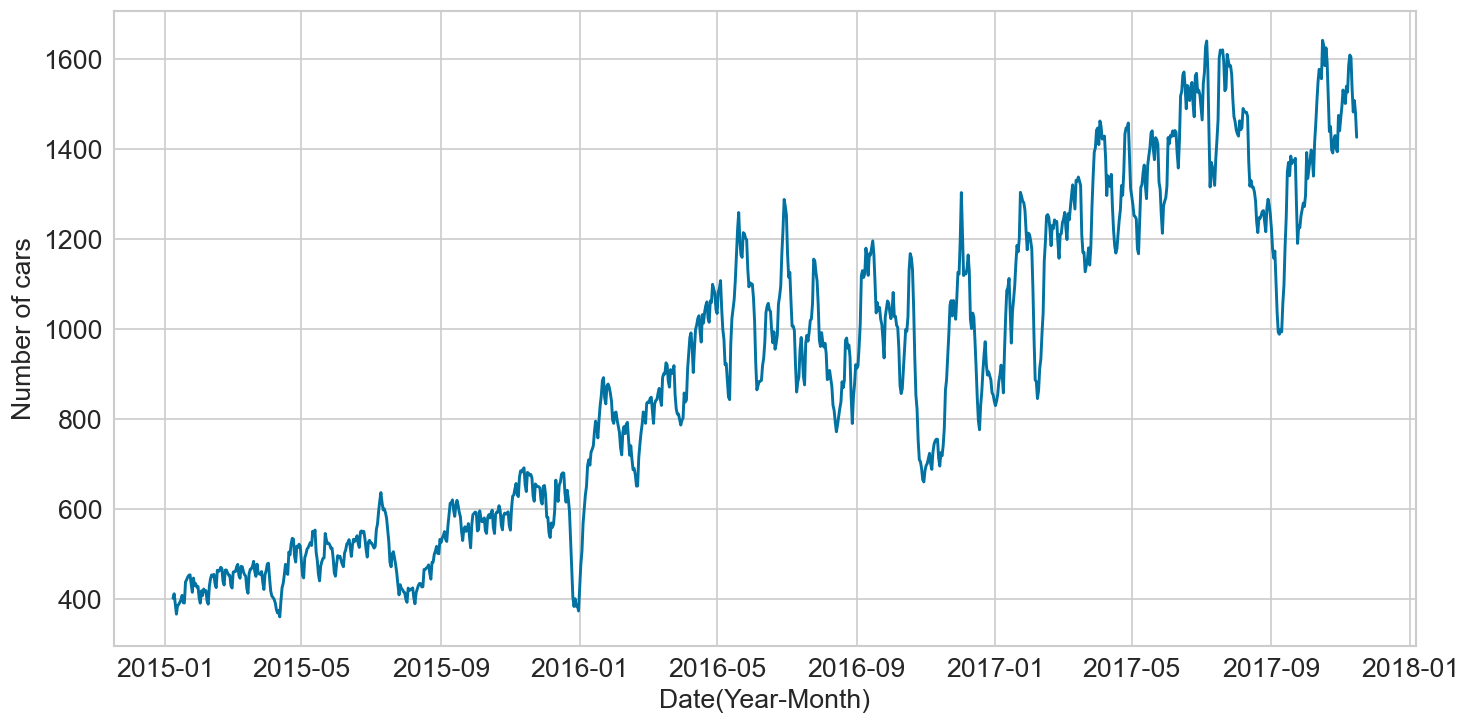

In [116]:
#Visualizing number of cars over time
plt.figure(figsize=(14,7))
plt.plot(Date_Sum.NumberofCars.rolling(8).mean())
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Date(Year-Month)", fontsize=16)
plt.ylabel("Number of cars", fontsize=16)

<font size="3"> According to the above figure, the number of cars that cross the road segment has been increasing continuously (assuming the samples indicate what really has happened). Results in section 4.1, indicated that the maximum average hourly speed has dropped starting from November 2016. For that, one possible reason could be the rise in the number of cars that cross the road as presented in the above figure.

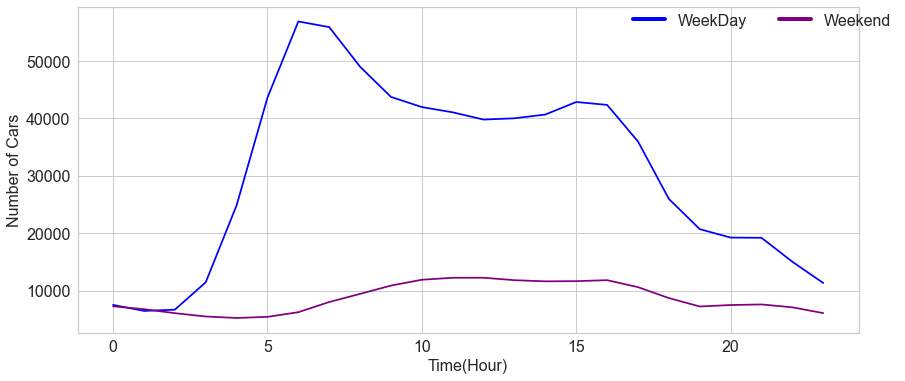

In [30]:
#Visualizing the number of cars by DayType(weekend vs weekday)
plt.figure(figsize = (14,6))
plt.plot(DayClassHour_Sum.iloc[0,0:24].values, c= 'blue')
plt.plot(DayClassHour_Sum.iloc[1,0:24].values, c= 'purple')

matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Time(Hour)", fontsize=16)
plt.ylabel("Number of Cars", fontsize=16)
#matplotlib. pyplot. xticks(rotation=60)
colors = ['blue','purple']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['WeekDay', 'Weekend']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.,ncol=2, fontsize=16,markerscale=4, title_fontsize='40')
#consistency in time classes

<font size="3">  According to the above figure, the number of cars per hour for weekends and weekdays are different. During weekdays, the number of cars per hour has a peak around 7 am. On weekends, the flow reaches its maximum between 10 am and 3 pm.

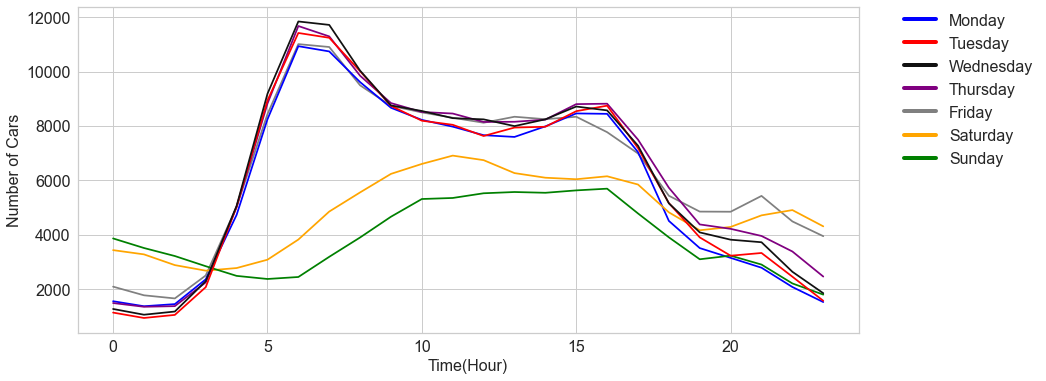

In [32]:
#Visualizing the number of cars per hour by day of the week
plt.figure(figsize = (14,6))
colors = ['gray',  'blue', 'orange', 'green', 'purple', 'red','k']
for i in range(0,DayofWeekHour_Sum.shape[0]):
    plt.plot(DayofWeekHour_Sum.iloc[i,0:24].values, c= colors[i])    
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Time(Hour)", fontsize=16)
plt.ylabel("Number of Cars", fontsize=16)
#matplotlib. pyplot. xticks(rotation=60)
colors = ['blue', 'red', 'k','purple','gray','orange','green']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['Monday', 'Tuesday','Wednesday','Thursday','Friday' , 'Saturday','Sunday']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=1, fontsize=16,markerscale=4, title_fontsize='40')
#consistency in time classes    

<font size="3"> The above figure further breaks the daily distribution of the number of cars per hour by day of the week. The results solidified what we read from the previous figure. 

## Correlation between Speed and Number of Cars

In [117]:
#summing the number of cars by date and hour and including date and hour in the created columns 
#Indicator is a constant(unit) value to help count number of cars by different categorical variables
DataCaseStudy_Traffic['Indicator'] = np.repeat(1,DataCaseStudy_Traffic.shape[0])
DateHour_Sum = DataCaseStudy_Traffic[['Date','Hour','Indicator']].groupby(['Date','Hour']).sum()
DateHour_Sum['Date'] = DateHour_Sum.index.get_level_values(0)
DateHour_Sum['Hour'] = DateHour_Sum.index.get_level_values(1)
DateHour_Sum.columns = ['NumberofCar', 'Date', 'Hour']

In [118]:
#Computing the mean speed and map matching error by date and hour
DateHour_Mean = DataCaseStudy_Traffic[['Date','Hour','Speed_kph', 'MapMatchingError_m']].groupby(['Date','Hour']).mean()
DateHour_Mean['Date'] = DateHour_Mean.index.get_level_values(0)
DateHour_Mean['Hour'] = DateHour_Mean.index.get_level_values(1)

Text(0, 0.5, 'Number of Cars')

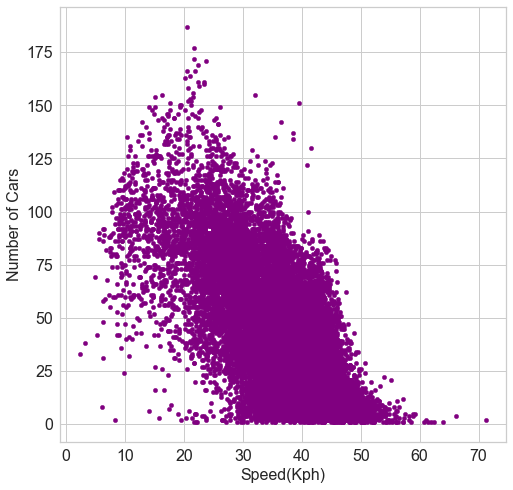

In [34]:
#making a scatter plot that show speed vs. number of cars
plt.figure(figsize=(8,8))
plt.scatter(DateHour_Mean.Speed_kph, DateHour_Sum.NumberofCar, c='purple', s=20)
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Speed(Kph)", fontsize=16)
plt.ylabel("Number of Cars", fontsize=16)


<font size="3"> The above scatter plot presents the relationship between the hourly average speed of cars and the number of cars per hour. The plot shows an inverse linear relationship between the number of cars and the average speed of the cars as expected. In Section 4.3 we found that the average speed on weekdays reaches its lowest at around 7 am which could be the result of increased congestion that happened at the same time as presented in Section 4.6.   

## MapMatchingError by ProbeSource

In [119]:
#Computing the mean by map matching error by ProbeSource and Date
DateProbeSource_Mean = DataCaseStudy_Traffic[['Date','ProbeSource','MapMatchingError_m']].groupby(['Date','ProbeSource']).mean()
DateProbeSource_Mean = DateProbeSource_Mean.unstack(level='ProbeSource')
#DateProbeSource_Mean['DateProbeSource_Mean'] = DateProbeSource_Mean.index.get_level_values(1)

In [120]:
#Counting how many times each ProbeSource used by day 
ProbeSource_Count = DataCaseStudy_Traffic[['Date','ProbeSource','Indicator']].groupby(['Date','ProbeSource']).sum()
ProbeSource_Count = ProbeSource_Count.unstack(level='ProbeSource')
ValidValuesProbeSource_Count = ProbeSource_Count.count() # to find the number of valid cases

In [121]:
#Creating a dataframe that contain the number of times each ProbeSource
#There are 20 ProbeSources
ValidValues_df = pd.DataFrame(ProbeSource_Count.count())
ValidValues_df.columns  = ['ValidValues'] # ValidValues is number of non NaN values by ProbeSource
ValidValues_df['ProbeSource'] = ValidValues_df.index.get_level_values(1)

In [122]:
#Sort the number of ValidValues then pick the first 10 commonly used ProbeSources for visualization
ValidValues_df_Sort = ValidValues_df.sort_values('ValidValues',ascending=False).reset_index(drop=True)
ValidValuesProbeSource_Sort_Top10 = ValidValues_df_Sort.iloc[0:11, : ]

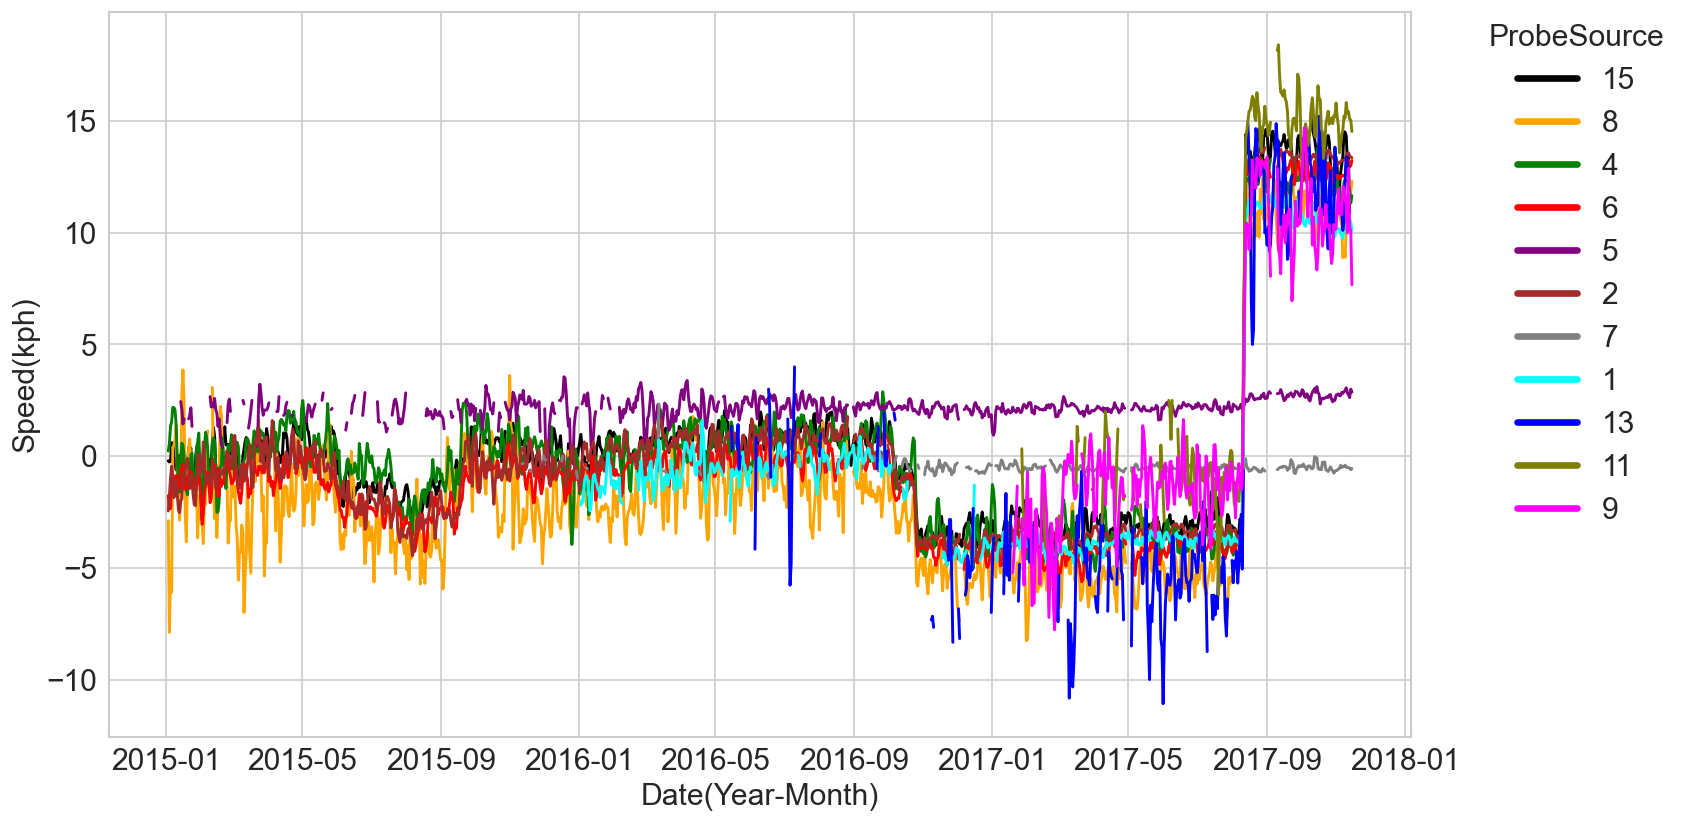

In [124]:

#making line plots that presents the difference in mapmatching errors by ProbeSources
cols= ['black', 'orange','green','red','purple','brown','gray','cyan','blue','olive', 'Magenta']
plt.figure(figsize=(14,8))
j=0
for i in ValidValuesProbeSource_Sort_Top10.ProbeSource.values:
    plt.plot(DateProbeSource_Mean.iloc[:,i].rolling(3).mean(), c=cols[j])
    j=j+1
        
matplotlib.rc('xtick', labelsize=18)
matplotlib.rc('ytick', labelsize=18)
plt.xlabel("Date(Year-Month)", fontsize=18)
plt.ylabel("Speed(kph)", fontsize=18)
colors = cols
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels =  list(ValidValuesProbeSource_Sort_Top10.ProbeSource.values)
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,ncol=1, fontsize=18,markerscale=4, 
           title_fontsize='18', title='ProbeSource')

<font size="3"> According to the above figure, the mean and the variation of two of the ProbeSources are different. ProbeSource 5 and 7 shows consistency in the average map matching error. The means for map matching error of ProbeSource 5 and ProbeSource 7 are approximately 3 meters and 0 meters respectively. The remaining ProbeSources shows a pattern that suddenly rises and falls and then stays at the same level for a certain period.    

# Forecasting Hourly Number of Cars

<font size="3"> The aim of the data analysis in this section is to forecast the hourly traffic congestion based on the sample dataset. The assumption here is the proportion of cars that report speed is proportional over time. To train a time series model that predicts the number of cars per hour, the data need to be first aggregated by date and hour. In this part, the SARIMA model that accommodates the daily seasonal pattern was trained using part of the dataset. 

## Data preparation

In [125]:
#Counting the number of cars by Date and Hour using group by function and then include them as columns  
#indicator is a constant value included to facilitate counting the number of cars by Date and Hour
DataCaseStudy_Traffic['Indicator'] = np.repeat(1,DataCaseStudy_Traffic.shape[0])
DateHour_Count = DataCaseStudy_Traffic[['Date','Hour','Indicator']].groupby(['Date','Hour']).count()
DateHour_Count.columns = ['NumberofCars']
DateHour_Count['Date'] = DateHour_Count.index.get_level_values(0)
DateHour_Count['Hour'] = DateHour_Count.index.get_level_values(1)   
DateHour_Count = DateHour_Count.reset_index(drop=True)

In [134]:
DateHour_Count['NumberofCars'].count()

25155

<font size="3"> According to the above value, the number of available values is 25155. However, if there are no missing values between 1st of January 2015 (2015-1-1 00:00) and 15th of November 2017 (2017-11-15 18:00) the number of available values should be 25194. Therefore 39 hourly values are missing. 
<font size="3">  To estimate the missing values, I first find the average hourly number of cars for each day (Monday to Sunday). Then, I replaced the missing values with the computed mean number of cars by considering the day and hour. 

In [137]:
#Creating a datetime variable that has only the date and hour  
DateHour_Count['Date_Hour']=DateHour_Count.apply(lambda x:'%s %s:00' % (x['Date'],x['Hour']),axis=1)
DateHour_Count['Date_Hour'] = pd.to_datetime(DateHour_Count.Date_Hour)

In [148]:
#Subsetting Date_Hour and number of cars then making the date time the index of the dataframe
DataForARIMA = DateHour_Count[['Date_Hour','NumberofCars']]
DataForARIMA.columns = ['Date_Hour','NumberofCars']
DataForARIMA = DataForARIMA.set_index('Date_Hour') 

In [149]:
# A function that generate a hourly sequence
def daterange(start_date, end_date):
    """
    This function accepts the sarting time
    and end time and generates a hourly sequence
    """
    
    delta = datetime.timedelta(hours=1)
    while start_date < end_date:
        yield start_date
        start_date += delta

In [150]:
#Generating and storing a hourly sequence. The starting and end time points are taken from the provided dataset 
start_date = datetime.datetime(2015, 1, 1, 00, 00)
end_date = datetime.datetime(2017, 11, 15, 18, 00)
complete_hourly_list = []
for single_date in daterange(start_date, end_date):
    complete_hourly_list.append(single_date.strftime("%Y-%m-%d %H:%M"))

In [151]:
#Define the creted regular hourly sequence as data frame. This is to prepare the dataframe for merge
complete_hourly_list = pd.DataFrame(pd.to_datetime(complete_hourly_list))
complete_hourly_list.columns = ['Timestamp']
complete_hourly_list = complete_hourly_list.set_index('Timestamp') 
DataForARIMACorrected = complete_hourly_list.merge(DataForARIMA, how='left', left_index=True, right_index=True)

In [152]:
# Create a day-Hour combination variable. This is to get the average car count by day and hour.
# The computed value will be used to fill the missing values 
DataForARIMACorrected['Timestamp'] = DataForARIMACorrected.index
DataForARIMACorrected['Hour'] = DataForARIMACorrected.Timestamp.dt.hour
DataForARIMACorrected['Day'] = DataForARIMACorrected.Timestamp.dt.dayofweek
DataForARIMACorrected['DayHour']=DataForARIMACorrected.apply(lambda x:'%s%s' % (x['Day'],x['Hour']),axis=1)
DayHour_Count = DataForARIMACorrected[['DayHour','NumberofCars']].groupby(['DayHour']).mean()
DayHour_Count['DayHour'] = DayHour_Count.index.get_level_values(0)

In [153]:
#First finding the by day and hourly car count dataset with missing values. 
#Then replace it with the by day and hourly mean car counts computed from the rest (availablevalues)
DataWithEmptyCells = DataForARIMACorrected[DataForARIMACorrected.NumberofCars.isnull()]
EstimatedValues = []
for i in range(DataWithEmptyCells.shape[0]):
    EstimatedValues.append(DayHour_Count[DayHour_Count.DayHour == DataWithEmptyCells.DayHour[i]].NumberofCars.values)
DataWithEmptyCells['NumberofCars'] = list(flatten(EstimatedValues))
DataForARIMACorrected_DropNaN = DataForARIMACorrected[DataForARIMACorrected['NumberofCars'].notna()]
DataForARIMACorrected_Filled = DataForARIMACorrected_DropNaN.append(DataWithEmptyCells)
DataForARIMACorrected_Filled = DataForARIMACorrected_Filled.sort_index()
DataForARIMACorrected_Filled = DataForARIMACorrected_Filled.drop('Timestamp',axis=1)

<ipython-input-153-0abe1dd70385>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataWithEmptyCells['NumberofCars'] = list(flatten(EstimatedValues))


## Fitting SARIMA model

<font size="3">  The following SARIMA model was fitted for the number of cars per hour data after imputing the missing values. I was forced to fit the model for part of the data because of the memory requirement of SARIMA in Python especially for higher orders of autoregressive and moving average terms. Therefore the fitted model is for part of the data and considered a limited range of autoregressive, moving average, and differencing terms. 

In [158]:
# Subsetting data starting from 15th of september 2016(2016-09-15 00:00:00 )
DataForARIMACorrected_Filled_Subset = DataForARIMACorrected_Filled.iloc[14952:,:]#.reset_index(drop=True)

In [161]:
#Splitting the series as train set and test set
Train = DataForARIMACorrected_Filled_Subset.NumberofCars[0:9888].values#9888 values
Test = DataForARIMACorrected_Filled_Subset.NumberofCars[9888:].values#354values

In [54]:
#Searching for a right orde for the regular and seasonal autoregressive, moving average, and differencing terms
Arima_model=auto_arima(Train, start_p=0, start_q=0, max_p=2, max_q=2, start_P=0, start_Q=0, max_P=1, max_Q=1, m=24, seasonal=True, trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[24]             : AIC=86043.039, Time=0.58 sec
 ARIMA(1,1,0)(1,1,0)[24]             : AIC=84207.942, Time=5.56 sec
 ARIMA(0,1,1)(0,1,1)[24]             : AIC=inf, Time=12.09 sec
 ARIMA(1,1,0)(0,1,0)[24]             : AIC=85471.402, Time=0.64 sec
 ARIMA(1,1,0)(1,1,1)[24]             : AIC=inf, Time=30.29 sec
 ARIMA(1,1,0)(0,1,1)[24]             : AIC=inf, Time=16.44 sec
 ARIMA(0,1,0)(1,1,0)[24]             : AIC=84542.837, Time=4.36 sec
 ARIMA(2,1,0)(1,1,0)[24]             : AIC=84159.750, Time=9.40 sec
 ARIMA(2,1,0)(0,1,0)[24]             : AIC=85359.527, Time=1.39 sec
 ARIMA(2,1,0)(1,1,1)[24]             : AIC=inf, Time=47.01 sec
 ARIMA(2,1,0)(0,1,1)[24]             : AIC=inf, Time=21.90 sec
 ARIMA(2,1,1)(1,1,0)[24]             : AIC=inf, Time=76.26 sec
 ARIMA(1,1,1)(1,1,0)[24]             : AIC=inf, Time=59.83 sec
 ARIMA(2,1,0)(1,1,0)[24] intercept   : AIC=84161.750, Time=33.16 sec

Best model:  ARIMA(2,1,0)(1,1,0)[24]  

In [55]:
#Fitting the model
Arima_model.fit(Train)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(1, 1, 0, 24),
      suppress_warnings=True, with_intercept=False)

In [56]:
#Summary of the fitted summary
Arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 9888
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 24)   Log Likelihood              -42075.875
Date:                            Sat, 22 May 2021   AIC                          84159.750
Time:                                    23:50:22   BIC                          84188.536
Sample:                                         0   HQIC                         84169.500
                                           - 9888                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1995      0.008    -26.182      0.000      -0.214      -0.185
ar.L2         -0.0715      0.008     -8.991      0.000      -0.087      -0.056
ar.S.L24      -0.3452      0.008    -44.203      0.000      -0.360      -0.330
sigma2       297.0424      3.067     96.865      0.000     291.032     303.053
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):              1386.00
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<font size="3"> The auto_arima function search for orders of the regular and seasonal autoregressive, moving average, and differencing that minimizes the Akaike Information Criterion (AIC). Accordingly, the best model according to the criterion is a model that has two regular autoregressive, one moving average, one seasonal autoregressive, one seasonal moving average, and no differencing. 

## Forecasting Using SARIMA

<font size="3"> After fitting the ARIMA model that has two regular autoregressive, one regular moving average, one seasonal autoregressive, and one seasonal moving average. I forecasted the hourly number of cars for the 1st and 2nd of November 2017. One problem with the SARIMA model is that it is less successful when there are multiple sources of seasonality. The hourly car count data has multiple sources of seasonality such as hour, day of the week, weeks, months, and seasons. 

In [57]:
# Forecasting the first two days of November 2017
forecast = Arima_model.predict(n_periods=48)

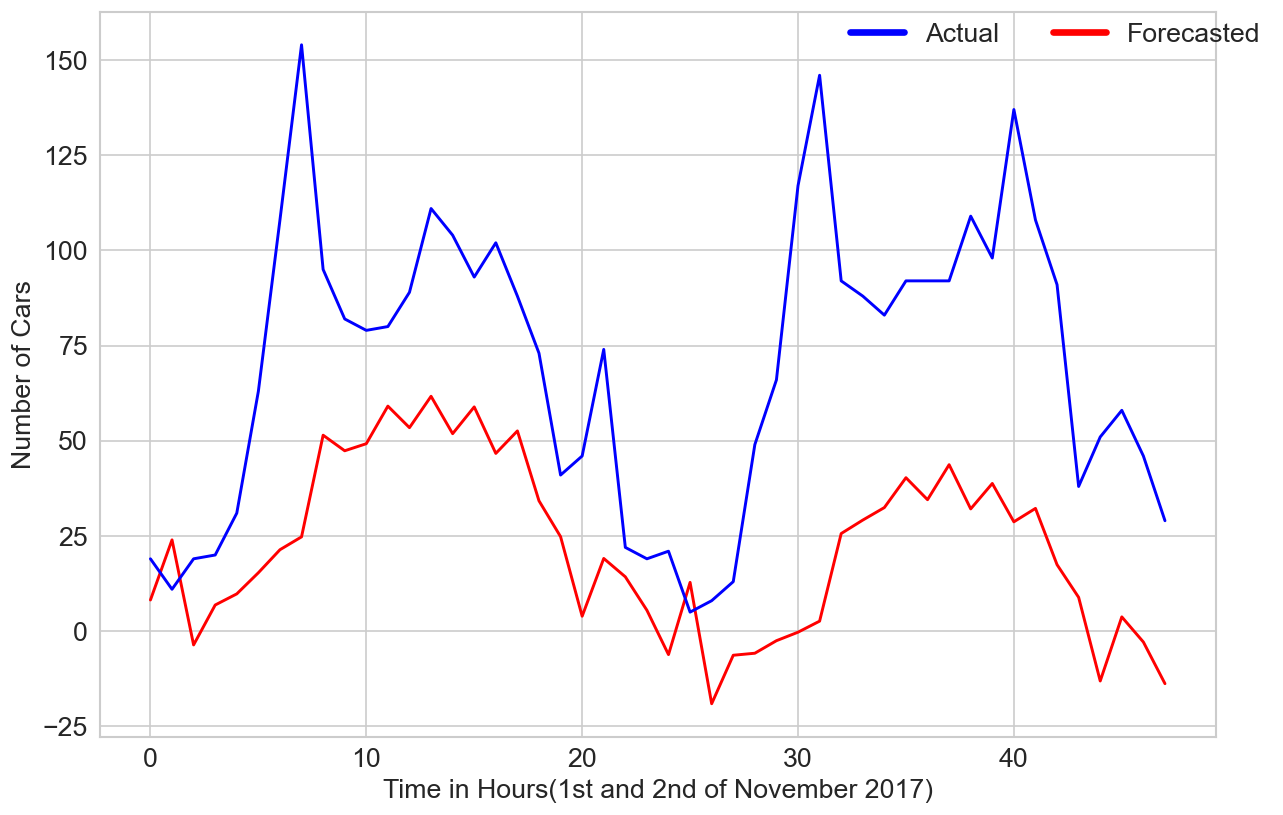

In [171]:
plt.figure(figsize=(12,8))
plt.plot(forecast, c= 'red')
plt.plot(Test[0:48], c= 'blue')
matplotlib.rc('xtick', labelsize=16)
matplotlib.rc('ytick', labelsize=16)
plt.xlabel("Time in Hours(1st and 2nd of November 2017)", fontsize=16)
plt.ylabel("Number of Cars", fontsize=16)
colors = ['blue',  'red']
lines = [Line2D([0], [0], color=c, linewidth=4, linestyle='-') for c in colors]
labels = ['Actual', 'Forecasted']
plt.legend(lines, labels,bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.,ncol=4, fontsize=16,markerscale=3, title_fontsize='20')


In [62]:
# evaluation, MSE and RMSE for forecast
mse_forecast = mean_squared_error(forecast, Test[0:48])
rmse_forecast = math.sqrt(mse_forecast)

In [65]:
#The root mean squared value
print(rmse_forecast)

57.3802004547795


<font size="3"> The root mean squared error of the forecast is 57.38

# Summary

<font size="3"> The summary points based on the result obtained are:
<ul><ul><li> During weekdays the average speed reaches the lowest point at around 7 am it is also the time by which the number of cars per hour reaches the highest level. The average speed dropped especially starting from November 2016.</li>
&nbsp;<li> The speed and number of cars per hour patterns are different for weekends and weekdays.</li> 
&nbsp;<li>  ProbeSource 5 and 7 relatively have consistent and lower map matching errors.</li>
&nbsp;<li>  There is an inverse linear relationship between the average car speed the number of cars per hour.</li>
&nbsp;<li>  SARIMA model was used to forecast the hourly number of cars per hour data. However, the SARIMA model has limitations especially since the data has multiple sources of seasonality.</li>
    </font>  


# Appendix

In [ ]:
#Checking assumptions of ARIMA model

In [67]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(Train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -8.549518
p-value: 0.000000


The null hypothesis in the ADF test of stationarity is the time series are non-stationary. The p value we obtained is approximately zero. Therefore, we can be confident on the stationarity of the time series. 

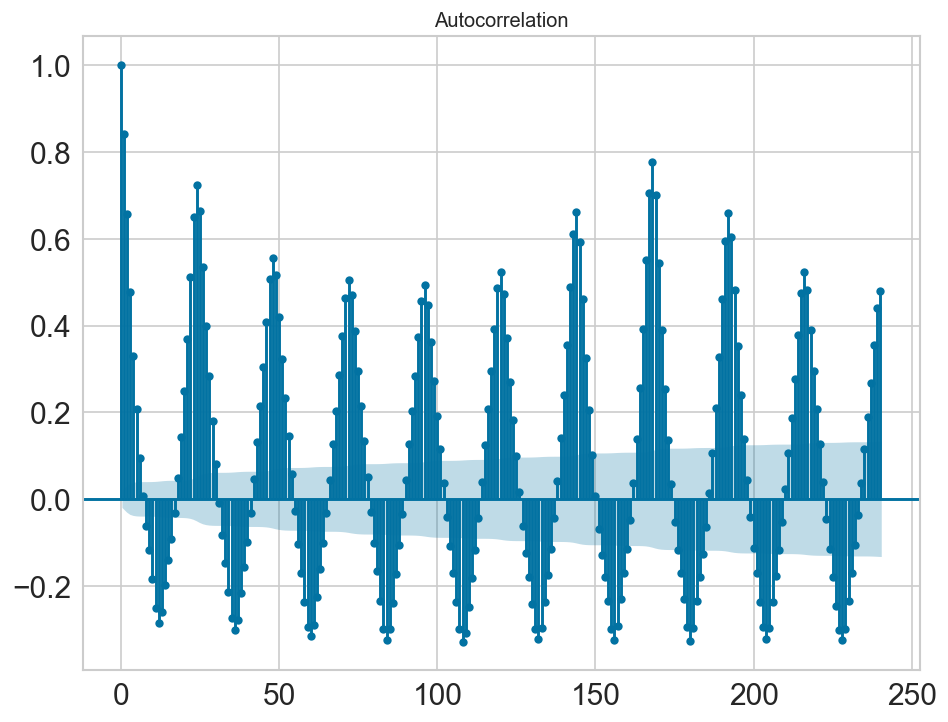

In [76]:
sm.graphics.tsa.plot_acf(Train.squeeze(), lags=240)
plt.show()

<font size="3"> The ACF plot of the number of cars per hour indicates the presence of strong autocorrelations. The first strong autocorrrelation appears every 24 hours i.e. every 24, 48,... hours.The second autocorrelation is weekly, every 168,336,... hours.  